<a href="https://colab.research.google.com/github/psgrigoletti/margem-liquida-colab/blob/main/teste_markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Teoria moderna do portfólio**

A teoria moderna do portfólio, ou simplesmente teoria do portfólio, explica como investidores racionais irão usar o princípio da diversificação para otimizar as suas carteiras de investimentos, e como um ativo arriscado deve ser precificado. O desenvolvimento de modelos de otimização de portfólio tem origem na área econômico-financeira.

O trabalho pioneiro na área de otimização de portfólio foi à proposição do modelo média-variância por Markowitz (1952).] A teoria do portfólio estabelece que decisões relacionadas à seleção de investimentos devam ser tomadas com base na relação risco-retorno. Para auxiliar neste processo, modelos de otimização de portfólio têm sido desenvolvidos. De modo a serem efetivos, tais modelos devem ser capazes de quantificar os níveis de risco e retorno dos investimentos.

**Referências**
- https://pt.wikipedia.org/wiki/Teoria_moderna_do_portf%C3%B3lio

- Código fonte original https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

- Índice de Sharpe: O que é e como impacta os seus investimentos? https://www.btgpactualdigital.com/como-investir/artigos/coluna-gustavo-cerbasi/indice-de-sharpe-o-que-e-e-como-impacta-os-seus-investimentos

- Markowitz’s Efficient Frontier in Python [Part 1/2] (https://medium.com/python-data/effient-frontier-in-python-34b0c3043314)

- Markowitz’s Efficient Frontier in Python [Part 2/2] (https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94)

- Investment Portfolio Optimization (http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html)

In [176]:
import investpy
import yfinance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight') # https://matplotlib.org/stable/gallery/style_sheets/fivethirtyeight.html
np.random.seed(777)

Definindo as ações que eu quero analisar, a data inicial e final para buscar o histórico dos preços de fechamento ajustados, valor da SELIC hoje (https://www.bcb.gov.br/controleinflacao/historicotaxasjuros, para ser usada como taxa livre de risco).

[*********************100%***********************]  6 of 6 completed
             BBAS3.SA  BBDC4.SA   BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
Date                                                                    
2016-01-04  10.592314  8.405844  14.070444  0.965201  5.180181     0.230
2016-01-05  10.629507  8.435621  14.970257  0.962046  5.036914     0.224
2016-01-06  10.629507  8.316065  14.853159  0.964570  4.825786     0.223
2016-01-07  10.376597  8.147793  14.267662  0.917887  4.720223     0.225
2016-01-08  10.376597  7.988378  14.538836  0.897069  4.727764     0.215


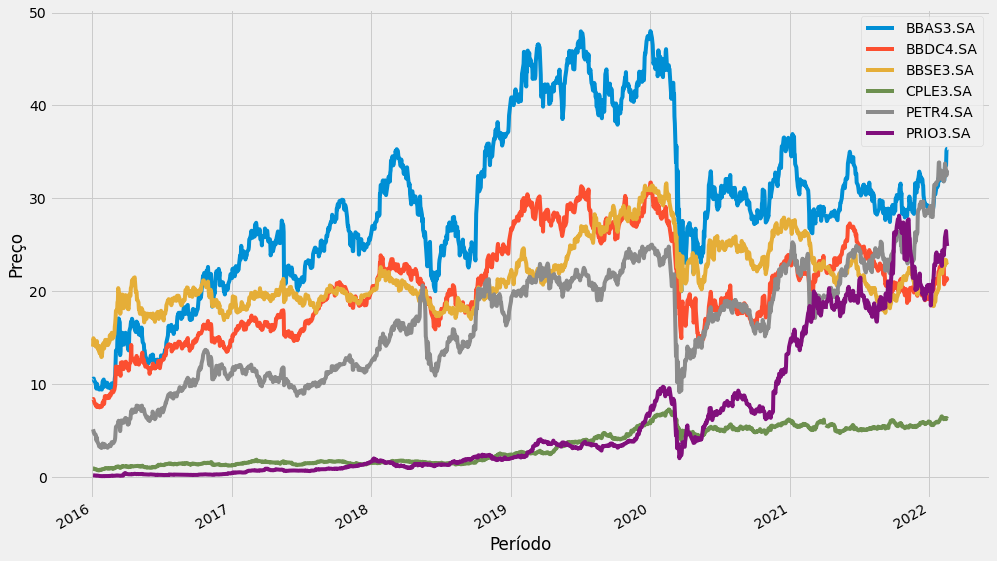

In [194]:
acoes = ['PRIO3', 'BBAS3', 'CPLE3', 'BBDC4', 'BBSE3', 'PETR4']
data_inicial = '2016-01-01'
data_final = '2022-02-18'
selic = 0.00915
numero_de_portfolis_aleatorios = 25000


table = yfinance.download(list(map((lambda x: x + ".SA"), acoes)), start=data_inicial, end=data_final)['Adj Close']

print(table.head())
table.plot(figsize=(15, 10), ylabel="Preço", xlabel="Período")

É possível plotar os **Retornos diários** (variação percentual em relação ao dia anterior). Ao traçar os retornos diários em vez dos preços reais, podemos ver a volatilidade das ações.

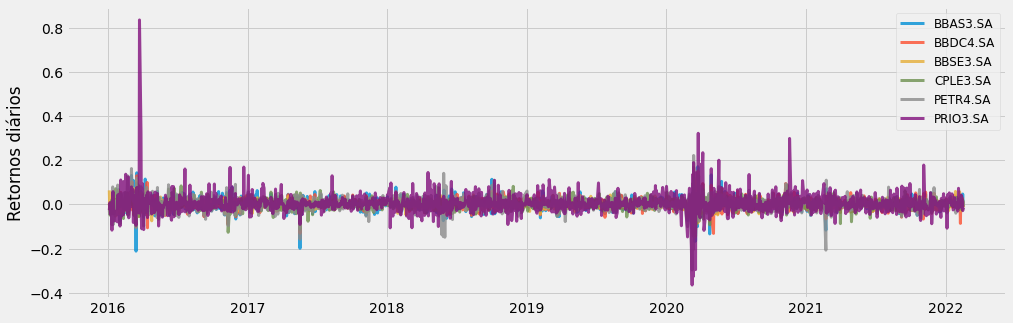

In [195]:
retornos = table.pct_change() # Percentage change between the current and a prior element.

plt.figure(figsize=(15, 5))
for c in retornos.columns.values:
    plt.plot(retornos.index, retornos[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Retornos diários')
plt.show()

# Geração de portfólios aleatórios

Temos *n* ações em nosso portfólio. Uma decisão que temos que tomar é como devemos alocar nosso orçamento para cada ação em nosso portfólio. Se nosso orçamento total for 1, podemos decidir os pesos para cada ação, de modo que a soma dos pesos seja 1. E o valor dos pesos será a parte do orçamento que alocamos para um estoque específico. Por exemplo, se o peso for 0,5 para a PETR4, significa que alocamos 50% do nosso orçamento para a PETR4.

Vamos definir algumas funções para simular pesos aleatórios para cada ação do portfólio e, em seguida, calcular os retornos globais anualizados e a volatilidade anualizada do portfólio.

A função **"portfolio_annualised_performance"** calculará os retornos e a volatilidade e, para fazer um cálculo anualizado, considero 252 como o número de dias de negociação em um ano. A função **"random_portfolios"** gerará portfólios com pesos aleatórios atribuídos a cada ação e, passando o argumento num_portfolios, você pode decidir quantos portfólios aleatórios deseja gerar.

In [196]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns


In [197]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(acoes))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

Você pode obter retornos diários facilmente chamando **pct_change** no data frame com os dados de preço. E os retornos médios diários, a matriz de covariância de retornos são necessários para calcular os retornos e a volatilidade do portfólio. Por fim, vamos gerar 50000 carteiras com pesos aleatórios atribuídos a cada ação. Este múmero pode ser ajustado nos parâmetros iniciais...



In [198]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = numero_de_portfolis_aleatorios
risk_free_rate = selic

Deixe-me explicar brevemente o que a função abaixo está fazendo. 

Primeiro, ele gera uma carteira aleatória e obtém os resultados (retornos da carteira, volatilidade da carteira, índice Sharpe da carteira) e pesos para o resultado correspondente. 

Em seguida, localizando aquele com o portfólio de índice de Sharpe mais alto, ele exibe o portfólio de índice de Sharpe máximo como sinal de estrela vermelha. E executa etapas semelhantes para o portfólio de volatilidade mínima e o exibe como a estrela verde no gráfico. Todas as carteiras geradas aleatoriamente também serão plotadas com mapa de cores aplicado a elas com base na razão de Sharpe. Quanto mais azul, maior a proporção de Sharpe.

E para esses dois portfólios ótimos, também mostrará como aloca o orçamento dentro do portfólio.

In [199]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.65
Annualised Volatility: 0.43


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation      6.93      0.37      3.12     39.34      8.79     41.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation      0.79      6.94      67.9     17.17      4.62      2.57


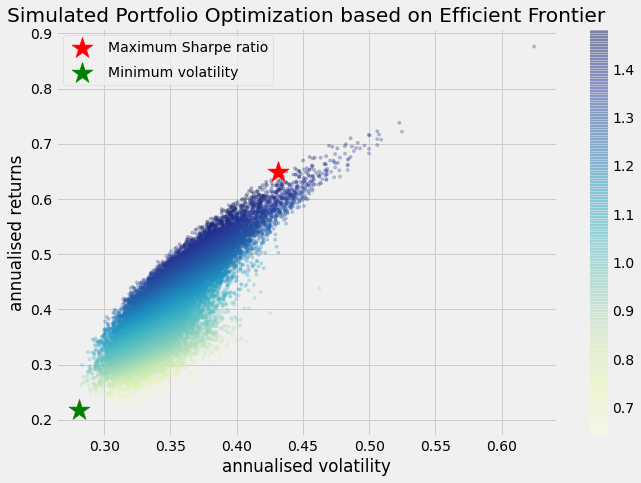

In [200]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Para carteira de risco mínimo, podemos ver que mais da metade do nosso orçamento é alocado ao BBSE3. Se você der outra olhada no gráfico de retorno diário anterior, verá que o BBSE3 é a ação menos volátil de quatro, portanto, alocar uma grande porcentagem ao BBSE3.SA para o portfólio de risco mínimo faz sentido intuitivo.

Se estivermos dispostos a assumir um risco maior para obter um retorno maior, aquele que nos dá o melhor retorno ajustado ao risco é aquele com índice de Sharpe máximo. Nesse cenário, estamos alocando uma parcela significativa para CPLE3 e PRIO3, que são ações bastante voláteis do gráfico anterior de retornos diários. E o BBSE que tinha mais de 50% de alocação na carteira de risco mínimo, tem um pouco mais de 3% do orçamento alocado para isso.

# Fronteira eficiente

A partir do gráfico do portfólio simulado aleatoriamente, podemos ver que ele forma uma linha de arco no topo de pontos azuis agrupados. Essa linha é chamada de **fronteira eficiente**. 

Por que é eficiente? Porque os pontos ao longo da linha lhe darão o menor risco para um determinado retorno alvo. Todos os outros pontos até a linha lhe darão maior risco com os mesmos retornos.* Se os retornos esperados são os mesmos, por que você assumiria um risco extra quando há uma opção com risco menor?*

A maneira como encontramos os dois tipos de portfólio ideal acima foi simulando muitas escolhas aleatórias possíveis e escolhendo as melhores (risco mínimo ou retorno ajustado ao risco máximo). Também podemos implementar isso usando a função de otimização do Scipy.

Se você é um usuário avançado do Excel, pode estar familiarizado com a função 'solver' no Excel. A função de otimização do Scipy está fazendo uma tarefa semelhante quando recebe o que otimizar e quais são as restrições e os limites.

As funções abaixo são para obter o portfólio máximo do índice Sharpe. Na função de otimização do Scipy não existe 'maximizar', então como função objetivo você precisa passar algo que deve ser minimizado. É por isso que o primeiro **"neg_sharpe_ratio"** está calculando o índice de Sharpe negativo. 

Agora podemos usar isso como nossa função objetivo para minimizar. Na função **"max_sharpe_ratio"**, você primeiro define os argumentos (isso não deve incluir as variáveis ​​que você gostaria de alterar para otimização, neste caso, "pesos"). No início, a construção das restrições foi um pouco difícil de compreender, devido à forma como é enunciada.

```
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
```

A restrição acima está dizendo que a soma de x deve ser igual a 1. Você pode pensar na construção da parte 'fun' como '1' no lado direito do sinal de igual foi movido para o lado esquerdo do sinal de igual.

```
'np.sum(x) == 1' se transformou em 'np.sum(x)-1'
```

E o que isto significa? Significa simplesmente que a soma de todos os pesos deve ser igual a 1. Você não pode alocar mais de 100% do seu orçamento no total.

Já a variável "bounds" está dando outro limite para atribuir pesos aleatórios, dizendo que qualquer peso deve estar inclusive entre 0 e 1. Você não pode atribuir menos alocação de orçamento a um estoque ou mais de 100% de alocação a um estoque.


In [184]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Também podemos definir a função de otimização para cálculo da carteira de volatilidade mínima. Desta vez, realmente minimizamos a função objetivo. 

O que queremos minimizar? Queremos minimizar a volatilidade tentando pesos diferentes. As variáveis "constraints" e "bounds" são as mesmas acima.

In [185]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

Como já mencionado acima, também podemos traçar uma linha que descreva onde devem estar as carteiras eficientes para uma determinada taxa de risco. Isso é chamado de **"fronteira eficiente"**. 

Abaixo defino outras funções para calcular a fronteira eficiente. A primeira função **"efficient frontier"** está calculando o portfólio mais eficiente para um determinado retorno-alvo, e a segunda função **"efficient_frontier"** obterá uma faixa de retornos-alvo e calculará o portfólio eficiente para cada nível de retorno.


In [186]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Vamos tentar traçar a escolha da carteira com o maior índice Sharpe e a volatilidade mínima também, com todas as carteiras geradas aleatoriamente. 

Mas desta vez não estamos escolhendo os ótimos dos portfólios gerados aleatoriamente, mas na verdade estamos calculando usando a função 'minimizar' do Scipy. E a função abaixo também traçará a linha de fronteira eficiente.


In [201]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.68
Annualised Volatility: 0.45


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0       0.0       0.0     52.94      2.23     44.83
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0      8.33     60.75     27.66       0.0      3.26


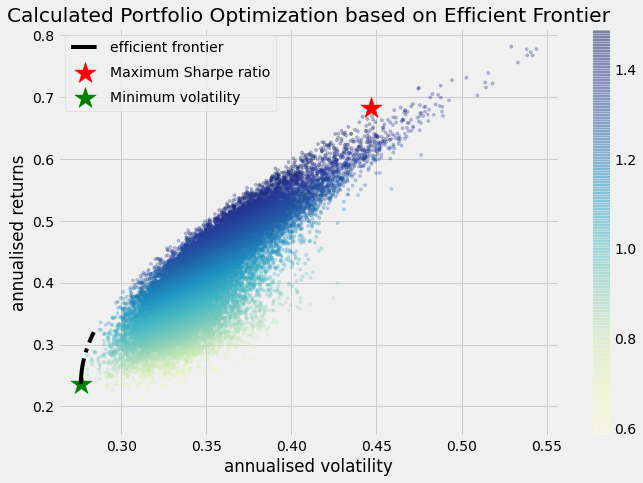

In [202]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Temos quase o mesmo resultado que simulamos escolhendo entre as carteiras geradas aleatoriamente. A pequena diferença é que a função "otimizar" do Scipy não alocou nenhum orçamento para o BBAS, BBDC e BBSE no portfólio de proporção máxima de Sharpe, enquanto uma que escolhemos das amostras geradas aleatoriamente tem alguma pequena alocação para estas ações. Existem algumas diferenças nas casas decimais, mas mais ou menos iguais.

Em vez de plotar cada carteira gerada aleatoriamente, podemos plotar cada ação individual no gráfico com os valores correspondentes do retorno anual e risco anual de cada ação. Dessa forma, podemos ver e comparar como a diversificação está diminuindo o risco, otimizando a alocação.

In [203]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(retornos) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.68
Annualised Volatility: 0.45


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0       0.0       0.0     52.94      2.23     44.83
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0      8.33     60.75     27.66       0.0      3.26
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BBAS3.SA : annuaised return 0.3 , annualised volatility: 0.44
BBDC4.SA : annuaised return 0.22 , annualised volatility: 0.38
BBSE3.SA : annuaised return 0.13 , annualised volatility: 0.3
CPLE3.SA : annuaised return 0.38 , annualised volatil

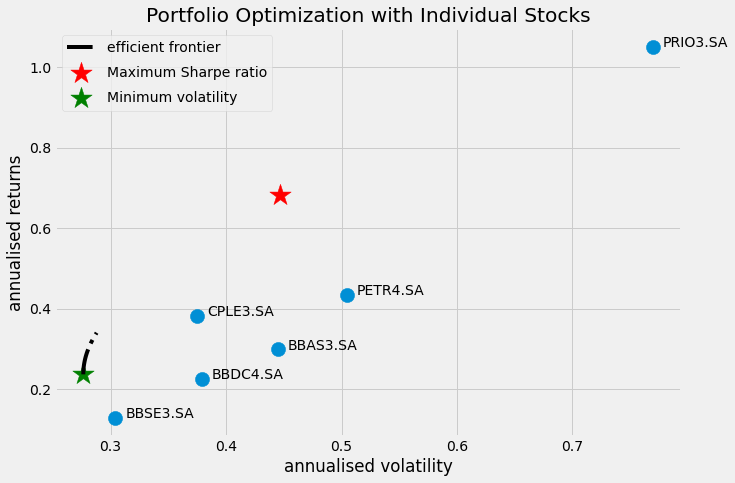

In [204]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)


Como você pode ver no gráfico acima, a ação com menor risco é o BBSE3 em torno de 0,3. Mas com a otimização do portfólio, podemos alcançar um risco ainda menor em 0,24 e ainda com um retorno maior que o BBSE3 ou BBDC4. E se estivermos dispostos a correr um pouco mais de risco em torno do nível semelhante de risco do BBAS3, podemos alcançar um retorno muito maior de 0,30 com a otimização do portfólio.